Author: Tim Gorman </br>

# Imports

In [2]:
import boto3
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [3]:
port_df = pd.read_json('/root/starbucks_offer_response_model/data/portfolio.json', orient = 'records', lines = True)
prof_df = pd.read_json('/root/starbucks_offer_response_model/data/profile.json', orient = 'records', lines = True)
trans_df = pd.read_json('/root/starbucks_offer_response_model/data/transcript.json', orient = 'records', lines = True)

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Renaming Columns

In [4]:
port_col_dict = {"id":"offer_id"}
prof_col_dict = {"id": "customer_id"}
trans_col_dict = {"person":"customer_id"}

In [5]:
port_df = port_df.rename(columns = port_col_dict)
prof_df = prof_df.rename(columns = prof_col_dict)
trans_df = trans_df.rename(columns = trans_col_dict)

Above is a list of the 10 offers that are available in the app and the relevant features. ID in this data frame is actually offer id, as opposed to the custoemr id in profile

# Feature Generation

### port_df

In [6]:
port_df

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
mlb = MultiLabelBinarizer()
port_df = port_df.join(pd.DataFrame(mlb.fit_transform(port_df.pop('channels')),
                          columns=mlb.classes_,
                          index=port_df.index))

In [9]:
port_df.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [10]:
port_df = port_df.merge(pd.get_dummies(port_df['offer_type'].copy()), left_index = True, right_index = True)

In [11]:
port_df = port_df.drop(columns = ['offer_type'])

In [12]:
port_df.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


## prof_df

In [13]:
prof_df.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
prof_df = prof_df.merge(pd.get_dummies(prof_df['gender'].fillna('no_G').copy()), left_index = True, right_index = True)
prof_df.head()

,gender,age,customer_id,became_member_on,income,F,M,O,no_G
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,0,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,0,0,0,1


In [15]:
prof_df = prof_df.drop(columns = ['gender'])

In [16]:
prof_df = prof_df.merge(pd.get_dummies(pd.cut(prof_df['age'], bins = [17,42, 55, 66, 118], labels=['age1','age2', 'age3', 'age4'])), left_index = True, right_index = True)

In [17]:
prof_df = prof_df.drop(columns = ['age'])

In [18]:
prof_df.head()

,customer_id,became_member_on,income,F,M,O,no_G,age1,age2,age3,age4
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0,0,0,1,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0,0,0,1,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,0,0,0,1,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0,0,0,0,0,1
4,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,0,0,0,1,0,0,0,1


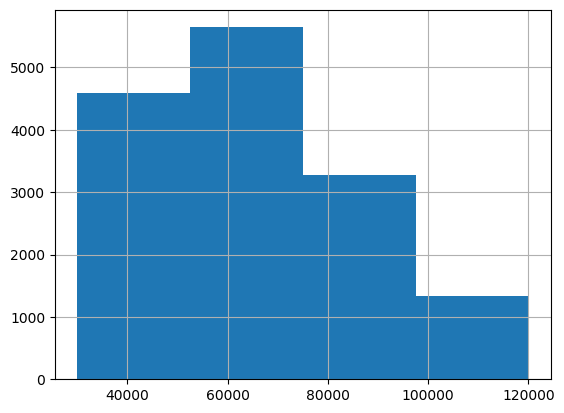

(52500.0, 75000.0]     5887
(29910.0, 52500.0]     4583
(75000.0, 97500.0]     3027
(97500.0, 120000.0]    1328
Name: income, dtype: int64

In [19]:
prof_df['income'].hist(bins = 4)
plt.show()
pd.cut(prof_df['income'], bins = 4).value_counts()

In [20]:
prof_df = prof_df.merge(pd.get_dummies(pd.cut(prof_df['income'], bins = 4, labels = ['inc1','inc2', 'inc3', 'inc4']).cat.add_categories("inc_miss").fillna("inc_miss")), left_index = True, right_index = True)

In [21]:
prof_df = prof_df.drop(columns = ['income'])

In [22]:
prof_df.head()

,customer_id,became_member_on,F,M,O,no_G,age1,age2,age3,age4,inc1,inc2,inc3,inc4,inc_miss
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,20170715,1,0,0,0,0,1,0,0,0,0,0,1,0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,0,0,0,1,0,0,0,1,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,1,0,0,0,0,0,0,1,0,0,0,1,0
4,a03223e636434f42ac4c3df47e8bac43,20170804,0,0,0,1,0,0,0,1,0,0,0,0,1


In [23]:
prof_df['years_as_member']=(2018-pd.to_datetime(prof_df['became_member_on'].astype('str'), format = '%Y%m%d').dt.year.astype('int'))

In [24]:
prof_df = prof_df.drop(columns = ['became_member_on'])

In [25]:
prof_df.head()

,customer_id,F,M,O,no_G,age1,age2,age3,age4,inc1,inc2,inc3,inc4,inc_miss,years_as_member
0,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,1,0,0,0,1,0,0,0,0,1,1
1,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,1,0,0,0,0,0,1,0,1
2,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,0,1,0,0,0,1,0,1
4,a03223e636434f42ac4c3df47e8bac43,0,0,0,1,0,0,0,1,0,0,0,0,1,1


### trans_df

In [26]:
trans_df['offer_id'] = None
trans_df['amount'] = None
trans_df['reward'] = None

In [27]:
trans_df

,customer_id,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,None,None,None
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,None,None,None
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,None,None,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,None,None,None
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,None,None,None
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None,None,None
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,None,None,None
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,None,None,None
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None,None,None


In [28]:
value_df = trans_df['value'].apply(pd.Series)

In [29]:
value_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [30]:
value_df.tail()

,offer id,amount,offer_id,reward
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN
306533,NaN,4.05,NaN,NaN


In [31]:
trans_df.loc[(trans_df['event'] == 'offer received'), 'offer_id'] = value_df['offer id']
trans_df.loc[(trans_df['event'] == 'offer viewed'), 'offer_id'] = value_df['offer id']
trans_df.loc[(trans_df['event'] == 'offer completed'), 'offer_id'] = value_df['offer_id']
trans_df.loc[(trans_df['event'] == 'offer completed'), 'reward'] = value_df['reward']
trans_df.loc[(trans_df['event']== 'transaction'), 'amount']  = value_df['amount']

In [32]:
trans_df = trans_df.drop(columns = ['value'])

In [33]:
trans_df[(trans_df['event'] == 'offer received')].head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,None
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,None
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,None,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,None,None
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,None


In [34]:
trans_df[(trans_df['event'] == 'offer viewed')].head()

,customer_id,event,time,offer_id,amount,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,None,None
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,None,None
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,None
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,None,None
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,None,None


In [35]:
trans_df[(trans_df['event'] == 'offer completed')].head()

,customer_id,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,None,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,None,2.0
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,5.0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,None,10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,10.0


In [36]:
trans_df[(trans_df['event'] == 'transaction')].head()

,customer_id,event,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,None,0.83,None
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,None,34.56,None
12659,54890f68699049c2a04d415abc25e717,transaction,0,None,13.23,None
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,None,19.51,None
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,None,18.97,None


# Merging the Data
After the merging step, I'd like a trans_df that has all info from the port_df and prof_df dataframes left joined to it.

In [37]:
len(trans_df)

306534

In [38]:
detailed_trans_df = trans_df.merge(port_df, how = 'left', on = 'offer_id').merge(prof_df, how = 'left', on = 'customer_id').copy()

In [39]:
len(detailed_trans_df)

306534

In [40]:
detailed_trans_df.head()

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,email,...,age1,age2,age3,age4,inc1,inc2,inc3,inc4,inc_miss,years_as_member
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,None,5.0,5.0,7.0,1.0,...,0,0,0,1,0,0,0,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,None,5.0,20.0,10.0,1.0,...,0,0,0,1,0,0,0,0,1,1
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,None,None,2.0,10.0,7.0,1.0,...,0,0,0,1,0,1,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,None,None,2.0,10.0,10.0,1.0,...,0,0,0,1,0,0,0,0,1,1
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,None,10.0,10.0,5.0,1.0,...,0,0,0,1,0,0,0,0,1,1


In [41]:
detailed_trans_df = detailed_trans_df.sort_values(by = ['customer_id', 'offer_id', 'time'])

In [42]:
detailed_trans_df = detailed_trans_df.reset_index().drop(columns = ['index'])

In [43]:
detailed_trans_df.head(10)

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,email,...,age1,age2,age3,age4,inc1,inc2,inc3,inc4,inc_miss,years_as_member
0,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,None,None,2.0,10.0,7.0,1.0,...,1,0,0,0,0,1,0,0,0,1
1,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,None,2.0,2.0,10.0,7.0,1.0,...,1,0,0,0,0,1,0,0,0,1
2,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,None,None,0.0,0.0,4.0,1.0,...,1,0,0,0,0,1,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,None,None,0.0,0.0,4.0,1.0,...,1,0,0,0,0,1,0,0,0,1
4,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,None,None,0.0,0.0,3.0,1.0,...,1,0,0,0,0,1,0,0,0,1
5,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,None,None,0.0,0.0,3.0,1.0,...,1,0,0,0,0,1,0,0,0,1
6,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,None,None,5.0,5.0,5.0,1.0,...,1,0,0,0,0,1,0,0,0,1
7,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,None,5.0,5.0,5.0,5.0,1.0,...,1,0,0,0,0,1,0,0,0,1
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,None,None,5.0,5.0,5.0,1.0,...,1,0,0,0,0,1,0,0,0,1
9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,None,None,2.0,10.0,10.0,1.0,...,1,0,0,0,0,1,0,0,0,1


# Generating the target label
We're going to make a label called "offer_successful". I'm going to assume that two offers don't go out at the same time or that once one 

In [44]:
target_df = detailed_trans_df[detailed_trans_df['event'] != 'transaction']

In [45]:
target_df = target_df[['customer_id', 'event', 'time', 'offer_id', 'duration']]

In [46]:
target_df.iloc[20]

customer_id    0011e0d4e6b944f998e987f904e8c1e5
event                              offer viewed
time                                        186
offer_id       2298d6c36e964ae4a3e7e9706d1fb8c2
duration                                    7.0
Name: 31, dtype: object

In [47]:
target_df.head(50)

,customer_id,event,time,offer_id,duration
0,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,7.0
1,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,7.0
2,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,4.0
3,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,4.0
4,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,3.0
5,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,3.0
6,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0
7,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5.0
9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,10.0


In [48]:
target_df.iloc[26]

customer_id    0011e0d4e6b944f998e987f904e8c1e5
event                            offer received
time                                        504
offer_id       9b98b8c7a33c4b65b9aebfe6a799e6d9
duration                                    7.0
Name: 37, dtype: object

In [49]:
if (target_df.iloc[26]['event'] == 'offer received'):
        print('received an offer')
        customer_id = target_df.iloc[26]['customer_id']
        offer_id =  target_df.iloc[26]['offer_id']
        duration = target_df.iloc[26]['duration']
        time_init = target_df.iloc[26]['time']
        #for j in target_df.index[i+1:]:
        if ((target_df.iloc[26+1]['customer_id'] == customer_id) & 
            (target_df.iloc[26+1]['offer_id']== offer_id) &
            (target_df.iloc[26+1]['event'] == 'offer viewed') &
            ((target_df.iloc[26+1]['time']-time_init)/24 <= duration) &
            (target_df.iloc[26+2]['customer_id'] == customer_id) & 
            (target_df.iloc[26+2]['offer_id']== offer_id) &
            (target_df.iloc[26+2]['event'] == 'offer completed') &
            ((target_df.iloc[26+2]['time']-time_init)/24 <= duration)
           ):
            #target_df.iloc[i]['offer_successful'] == 1
            print('victory')

received an offer
victory


In [50]:
len(target_df)

167581

In [51]:
target_df['offer_successful'] = 0
customer_id = None
for i in range(len(target_df)-2):
    if (target_df.iloc[i]['event'] == 'offer received'):
        customer_id = target_df.iloc[i]['customer_id']
        offer_id =  target_df.iloc[i]['offer_id']
        duration = target_df.iloc[i]['duration']
        time_init = target_df.iloc[i]['time']
        #for j in target_df.index[i+1:]:
        if ((target_df.iloc[i+1]['customer_id'] == customer_id) & 
            (target_df.iloc[i+1]['offer_id']== offer_id) &
            (target_df.iloc[i+1]['event'] == 'offer viewed') &
            ((target_df.iloc[i+1]['time']-time_init)/24 <= duration) &
            (target_df.iloc[i+2]['customer_id'] == customer_id) & 
            (target_df.iloc[i+2]['offer_id']== offer_id) &
            (target_df.iloc[i+2]['event'] == 'offer completed') &
            ((target_df.iloc[i+2]['time']-time_init)/24 <= duration)
           ):
            
            target_df.iloc[i, target_df.columns.get_loc('offer_successful')] = 1
        else:
            pass
    else:
        pass

In [52]:
len(target_df[target_df['offer_successful']==1])

23267

In [53]:
len(target_df[target_df['offer_successful']==1])/len(target_df)*100

13.884032199354342

In [54]:
target_df.head(50)

,customer_id,event,time,offer_id,duration,offer_successful
0,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,7.0,0
1,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,7.0,0
2,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,4.0,0
3,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,4.0,0
4,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,3.0,0
5,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,3.0,0
6,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0
7,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0
9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,10.0,0


In [55]:
target_df_2 = target_df[target_df['event']=='offer received']

In [56]:
len(target_df_2[target_df_2['offer_successful']==1])

23267

In [57]:
len(target_df_2)

76277

In [58]:
len(target_df_2[target_df_2['offer_successful']==1])/len(target_df_2)*100

30.503297193125057

In [59]:
labeled_df = detailed_trans_df[detailed_trans_df['event'] == 'offer received'].merge(target_df_2[['offer_successful']], left_index = True, right_index = True, how = 'left')

In [60]:
len(labeled_df)

76277

In [61]:
len(labeled_df[labeled_df['offer_successful']==1])/len(labeled_df)*100

30.503297193125057

In [62]:
labeled_df.head()

,customer_id,event,time,offer_id,amount,reward_x,reward_y,difficulty,duration,email,...,age2,age3,age4,inc1,inc2,inc3,inc4,inc_miss,years_as_member,offer_successful
0,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,None,None,2.0,10.0,7.0,1.0,...,0,0,0,0,1,0,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,None,None,0.0,0.0,4.0,1.0,...,0,0,0,0,1,0,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,None,None,0.0,0.0,3.0,1.0,...,0,0,0,0,1,0,0,0,1,0
6,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,None,None,5.0,5.0,5.0,1.0,...,0,0,0,0,1,0,0,0,1,0
9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,None,None,2.0,10.0,10.0,1.0,...,0,0,0,0,1,0,0,0,1,0


In [63]:
labeled_df = labeled_df.drop(columns = ['event', 'reward_x'])

In [64]:
labeled_df = labeled_df.reset_index().drop(columns = 'index')

In [65]:
labeled_df = labeled_df.rename(columns = {'reward_y':'reward'})

In [66]:
labeled_df = labeled_df.drop(columns = ['amount'])

In [67]:
labeled_df.head()

,customer_id,time,offer_id,reward,difficulty,duration,email,mobile,social,web,...,age2,age3,age4,inc1,inc2,inc3,inc4,inc_miss,years_as_member,offer_successful
0,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,...,0,0,0,0,1,0,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,...,0,0,0,0,1,0,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0


In [68]:
labeled_df.columns

Index(['customer_id', 'time', 'offer_id', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'F', 'M', 'O', 'no_G', 'age1', 'age2', 'age3', 'age4', 'inc1', 'inc2',
       'inc3', 'inc4', 'inc_miss', 'years_as_member', 'offer_successful'],
      dtype='object')

In [69]:
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       76277 non-null  object 
 1   time              76277 non-null  int64  
 2   offer_id          76277 non-null  object 
 3   reward            76277 non-null  float64
 4   difficulty        76277 non-null  float64
 5   duration          76277 non-null  float64
 6   email             76277 non-null  float64
 7   mobile            76277 non-null  float64
 8   social            76277 non-null  float64
 9   web               76277 non-null  float64
 10  bogo              76277 non-null  float64
 11  discount          76277 non-null  float64
 12  informational     76277 non-null  float64
 13  F                 76277 non-null  uint8  
 14  M                 76277 non-null  uint8  
 15  O                 76277 non-null  uint8  
 16  no_G              76277 non-null  uint8 

The label from above is "offer_successful" and the valid predictors are all other columns other than "customer_id", "time" and "offer_id"

In [73]:
labeled_df.to_csv('/root/starbucks_offer_response_model/data/curated_data/training_dataset.csv', index = False)

In [72]:
labeled_df.to_parquet('/root/starbucks_offer_response_model/data/curated_data/training_dataset.parquet', index = False)

# More work for a future iteration

Down the road, I could improve these features by summing the transaction history leading up to the time the offer was recieved and I could bin the customer profiles into age groups. I belive the sum of transaction history would provide a good indicator of likeliness to fulfill an offer and I think binning the customer profiles into age groups would allow me to indentify nonlinearities in response between different age groups with my linear models.